In [23]:
from collections import defaultdict
from functools import partial
import re

from colorama import Fore, Style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import torch
from torch import tensor as T
from tqdm.auto import tqdm

In [2]:
import os
os.environ["PYTHONOPTIMIZE"] = "1"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# STIM_SOURCE = "random"
STIM_SOURCE = "sentences"

In [5]:
from berp.generators import stimulus
from berp.generators.response import simple_gaussian
import berp.generators.thresholded_recognition_simple as gen
import berp.models.reindexing_regression as rr
from berp.util import gaussian_window

In [6]:
# Establish parameters used to synthesize data
# Obviously these will not be used during inference!

coef_mean = torch.tensor([-1.])
params = rr.ModelParameters(
    lambda_=torch.tensor(1.0),
    confusion=gen.phoneme_confusion,
    threshold=torch.distributions.Beta(1.2, 1.2).sample(),

    # NB only used for generation, not in model
    a=torch.tensor(0.2),
    b=torch.tensor(0.1),
    coef=coef_mean,
    sigma=torch.tensor(5.0),
)

print(f"{Style.BRIGHT}Critical parameters:{Style.RESET_ALL}")
print("Threshold:\t", params.threshold.item())
print("Noise sigma:\t", params.sigma.item())

Critical parameters:
Threshold:	 0.17194396257400513
Noise sigma:	 5.0


In [7]:
if STIM_SOURCE == "random":
    stim_gen = stimulus.RandomStimulusGenerator()
elif STIM_SOURCE == "sentences":
    text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, `and what is the use of a book,' thought Alice `without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
""".strip()
    # sentences = [s.strip().replace("\n", "") for s in re.split(r"[.?!]", text)]
    # sentences = [s for s in sentences if s]
    
    phonemes = np.array(list("abcdefghijklmnopqrstuvwxyz_"))
    stim_gen = stimulus.NaturalLanguageStimulusGenerator(
        phonemes=phonemes, hf_model="gpt2",
        phonemizer=None, num_candidates=1000, batch_size=8)
    
    tokenizer = stim_gen.processor._tokenizer
    tokenized = tokenizer(text)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer(text).input_ids)
    token_to_word = dict(enumerate(tokenized.word_ids()))
    word_to_token = defaultdict(list)
    for token, word in token_to_word.items():
        word_to_token[word].append(token)
    
    # TODO
    word_features = {word_id: torch.zeros(1) for word_id in word_to_token}
    
    stim_gen = partial(stim_gen, tokens, word_features, word_to_token, ground_truth_phonemes=None)

Using pad_token, but it is not set yet.


In [8]:
ds = gen.sample_dataset(params, stim_gen, response_type="n400")

  0%|          | 0/1 [00:00<?, ?batch/s]

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/berp/generators/response.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  signal = torch.tensor(signal)


In [9]:
p_candidates = rr.predictive_model(ds.p_word, ds.candidate_phonemes, confusion=params.confusion, lambda_=params.lambda_,
                                   return_gt_only=False)

In [26]:
# def get_topk(row, k=3):
#     return row[(-row).argsort()[:k]]

plot_data = []
k = 1000
for p_candidates_i, candidates, gt_length in zip(tqdm(p_candidates), ds.candidate_phonemes, ds.word_lengths):
    candidate_strs = ["".join(ds.phonemes[idx.item()].rstrip("_") for idx in word)
                      for word in candidates]
    plot_data_i = []
    
    p_candidates_i = p_candidates_i.T.numpy()[:gt_length]
    topk = (-p_candidates_i).argsort(1)[:, :k]
    p_candidates_i = np.take_along_axis(p_candidates_i, topk, 1)
    for t, (p_candidates_t, candidates_t) in enumerate(zip(p_candidates_i, topk)):
        plot_data_i.append((candidate_strs[0][:t + 1], list(zip(p_candidates_t, [candidate_strs[idx] for idx in candidates_t]))))
        
    plot_data.append(plot_data_i)

  0%|          | 0/108 [00:00<?, ?it/s]

In [27]:
import pickle
with open("plot_Data.pkl", "wb") as f:
    pickle.dump(plot_data, f)

0
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
0
0
1


[libopenh264 @ 0x565426f7d380] Incorrect library version loaded
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '432x288', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'test.m4v']' returned non-zero exit status 1.

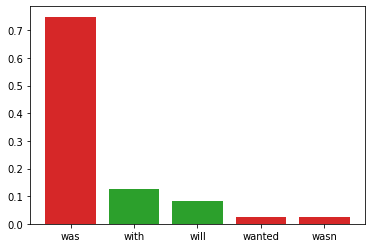

In [102]:
fig = plt.figure()
# barplot = plt.bar([""] * 3, [0] * 3)

def anim(i):
    incremental_text, dist = plot_data[i]
    xs = [word for _, word in dist]
    ys = [prob for prob, _ in dist]
    print(i)
    return plt.bar(xs, ys)
    
from matplotlib.animation import FuncAnimation

anim = FuncAnimation(fig, anim, blit=True, repeat=True, frames=5, interval=50)
anim.save("test.m4v")

In [ ]:
xs, ys = simple_gaussian(params.b, params.a, ds.sample_rate)
ys = params.coef[-1] * ys
plt.plot(xs, ys)

plt.title("Characteristic response in synthetic dataset")

In [ ]:
p_word_posterior = rr.predictive_model(ds.p_word, ds.candidate_phonemes, confusion=params.confusion, lambda_=params.lambda_)
recognition_points = rr.recognition_point_model(p_word_posterior, ds.word_lengths, threshold=params.threshold)
recognition_onsets = torch.gather(ds.phoneme_onsets, 1,
                                  recognition_points.unsqueeze(1)).squeeze(1)

In [ ]:
incremental_gt_probabilities = rr.predictive_model(ds.p_word, ds.candidate_phonemes, confusion=params.confusion, lambda_=params.lambda_)
incremental_gt_probabilities[:3]

In [ ]:
fig, ax = plt.subplots(figsize=(25, 7))
ax.plot(np.arange(ds.Y.shape[0]) / ds.sample_rate, ds.Y[:, 0], alpha=0.5)

annot_height = ax.get_ylim()[0] + 1

# Annotate word onset and phonemes
for i, word_onset in enumerate(ds.word_onsets + ds.phoneme_onsets[:, 0]):
    h_onset = ax.axvline(word_onset, c="orange", linestyle="--")
    for j, phoneme_onset in enumerate(word_onset + ds.phoneme_onsets[i]):
        phon = ds.phonemes[ds.candidate_phonemes[i, 0, j]]
        if phon != "_":
            font_weight = "bold" if j == recognition_points[i] else None
            ax.annotate(phon, xy=(phoneme_onset, annot_height), fontweight=font_weight)
# Annotate recognition onset
for rec_onset in ds.word_onsets + recognition_onsets:
    h_recognition = ax.axvline(rec_onset, c="green", linestyle="--")
    
# Annotate evidence climb to recognition
right_ax = ax.twinx()
h_threshold = right_ax.axhline(params.threshold, c="gray", linestyle="--", alpha=0.3)
for i, (length, phoneme_onsets, incremental_gt_prob) in enumerate(zip(ds.word_lengths, ds.word_onsets[:, None] + ds.phoneme_onsets, incremental_gt_probabilities)):
    xs = phoneme_onsets[:length]
    ys = incremental_gt_prob[:length]
    h_evidence, = right_ax.plot(xs, ys, c="gray", alpha=0.7)

ax.legend([h_onset, h_recognition, h_threshold, h_evidence],
          ["Word onset", "Recognition onset", "Evidence threshold", "Evidence accumulation"],
          loc='center left', bbox_to_anchor=(1.025, 0.5))
    
ax.set_xlim((1, 10))

In [ ]:
offsets = ((ds.recognition_onsets + ds.params.a - ds.epoch_window[0]).numpy() * ds.sample_rate).astype(int)
ds.Y_epoch[np.arange(len(ds.Y_epoch)), offsets + 3][:3]

In [ ]:
ds.p_word[:3, 0]

In [ ]:
ds.X_epoch[:3]

## N400 replication

In [ ]:
plt.plot(np.arange(ds.Y_epoch.shape[1]) / ds.sample_rate, ds.Y_epoch[3, :, 0])

In [ ]:
y_df = pd.DataFrame(ds.Y_epoch.numpy().squeeze())
y_df.index.name = "cum_token_idx"
y_df.columns.name = "epoch_sample"
y_df = y_df.unstack().rename("signal").reset_index()
y_df["time"] = y_df.epoch_sample / ds.sample_rate + ds.epoch_window[0]

In [ ]:
epoch_baselines = y_df[y_df.time <= 0].groupby("cum_token_idx").signal.mean()
y_df["signal_baselined"] = y_df.signal - y_df.cum_token_idx.map(epoch_baselines)

In [ ]:
ax = sns.lineplot(data=y_df, x="time", y="signal_baselined")
ax.axvline(0, c="gray")
ax.axhline(0, c="gray")

### N400 replication

With ground-truth recognition onset information, can we reproduce an N400 effect with ERP analysis?

In [ ]:
def time_window_to_sample(window, sample_rate, t_zero=0.):
    left, right = window
    
    left = int(np.floor((left - t_zero) * sample_rate))
    right = int(np.floor((right - t_zero) * sample_rate))
    return (left, right)

def compute_erp(dataset: rr.RRDataset,
                baseline_window=(-0.1, 0),
                test_window=None,
                use_recognition_onset=True
                ) -> pd.DataFrame:
    if test_window is None:
        test_window = (dataset.params.a, dataset.params.a + dataset.params.b)

    baseline_left_samp, baseline_right_samp = time_window_to_sample(baseline_window, dataset.sample_rate,
                                                                    t_zero=dataset.epoch_window[0])
    test_left_samp, test_right_samp = time_window_to_sample(test_window, dataset.sample_rate,
                                                            t_zero=dataset.epoch_window[0])
    
    if use_recognition_onset:
        recognition_onset_samp = np.floor(dataset.recognition_onsets * sample_rate).int().numpy()
        test_values = [dataset.Y_epoch[i, recognition_onset_samp_i + test_left_samp:recognition_onset_samp_i + test_right_samp, 0].mean()
                       for i, recognition_onset_samp_i in enumerate(recognition_onset_samp)]
        test_values = torch.stack(test_values)
    else:
        test_values = dataset.Y_epoch[:, test_left_samp:test_right_samp, 0].mean()
    
    baseline_values = dataset.Y_epoch[:, baseline_left_samp:baseline_right_samp, 0]

    return pd.DataFrame({"cum_token_idx": np.arange(len(dataset.Y_epoch)),
                         "baseline_value": baseline_values.mean(dim=1),
                         "test_value": test_values})

In [ ]:
erp_df = compute_erp(ds)
erp_df["surprisal"] = ds.X_epoch[:, 1].numpy()

In [ ]:
erp_df

In [ ]:
erp_df.sort_values("surprisal", ascending=False)

In [ ]:
# baseline_window = (-.1, 0)
# test_window = (0.3, 0.5)
# df_test = epochs.groupby(["item", "token_idx"]).apply(
#     lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
#                             "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))

In [ ]:
# merged_df = pd.merge(df_test, raw_dataset.X_word, left_index=True, right_index=True)
# merged_df["epoch_value_baselined"] = merged_df.epoch_value - merged_df.epoch_baseline

In [ ]:
erp_df["epoch_value_baselined"] = erp_df.test_value - erp_df.baseline_value

In [ ]:
sns.lmplot(data=erp_df, x="surprisal", y="epoch_value_baselined")

In [ ]:
st.pearsonr(erp_df.surprisal, erp_df.epoch_value_baselined)